# Diabetes Risk Assessment - Patient Segmentation Analysis

Comprehensive clustering analysis for diabetes patient risk stratification with advanced visualizations and clinical insights.

# Libraries and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Modern plotting style

In [2]:
plt.style.use('dark_background')
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8']
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Dataset Generation and Loading

In [3]:
np.random.seed(2024)
n_patients = 850

patient_data = {
    'glucose_level': np.random.gamma(2, 50, n_patients) + 80,
    'bmi': np.random.normal(27.5, 6.2, n_patients),
    'insulin_resistance': np.random.exponential(2.8, n_patients) + 1,
    'hba1c': np.random.normal(6.2, 1.4, n_patients),
    'triglycerides': np.random.gamma(3, 40, n_patients) + 80,
    'cholesterol_ratio': np.random.normal(4.2, 1.1, n_patients),
    'systolic_bp': np.random.normal(135, 18, n_patients),
    'family_history': np.random.binomial(1, 0.35, n_patients),
    'physical_activity': np.random.gamma(2, 1.5, n_patients),
    'stress_level': np.random.uniform(1, 10, n_patients)
}

for i in range(n_patients):
    if patient_data['bmi'][i] > 30:
        patient_data['glucose_level'][i] *= np.random.uniform(1.1, 1.4)
        patient_data['insulin_resistance'][i] *= np.random.uniform(1.2, 1.6)
        patient_data['systolic_bp'][i] += np.random.normal(15, 5)

diabetes_df = pd.DataFrame(patient_data)

diabetes_df['risk_score'] = (
    (diabetes_df['glucose_level'] - 90) * 0.02 +
    (diabetes_df['bmi'] - 25) * 0.05 +
    diabetes_df['insulin_resistance'] * 0.15 +
    (diabetes_df['hba1c'] - 5.7) * 0.3 +
    diabetes_df['triglycerides'] * 0.001 +
    (diabetes_df['cholesterol_ratio'] - 3.5) * 0.1 +
    (diabetes_df['systolic_bp'] - 120) * 0.01 +
    diabetes_df['family_history'] * 0.8 +
    (10 - diabetes_df['physical_activity']) * 0.05 +
    diabetes_df['stress_level'] * 0.08
)

diabetes_df['risk_score'] = np.clip(diabetes_df['risk_score'], 0, 10)

diabetes_df['diabetes_status'] = (diabetes_df['risk_score'] > 5.5).astype(int)

print(f"Diabetes Dataset Generated Successfully")
print(f"Dataset Dimensions: {diabetes_df.shape}")
print(f"Features: {list(diabetes_df.columns)}")
print(f"Diabetes Prevalence: {diabetes_df['diabetes_status'].mean():.1%}")

Diabetes Dataset Generated Successfully
Dataset Dimensions: (850, 12)
Features: ['glucose_level', 'bmi', 'insulin_resistance', 'hba1c', 'triglycerides', 'cholesterol_ratio', 'systolic_bp', 'family_history', 'physical_activity', 'stress_level', 'risk_score', 'diabetes_status']
Diabetes Prevalence: 26.5%


# Exploratory Data Analysis Dashboard

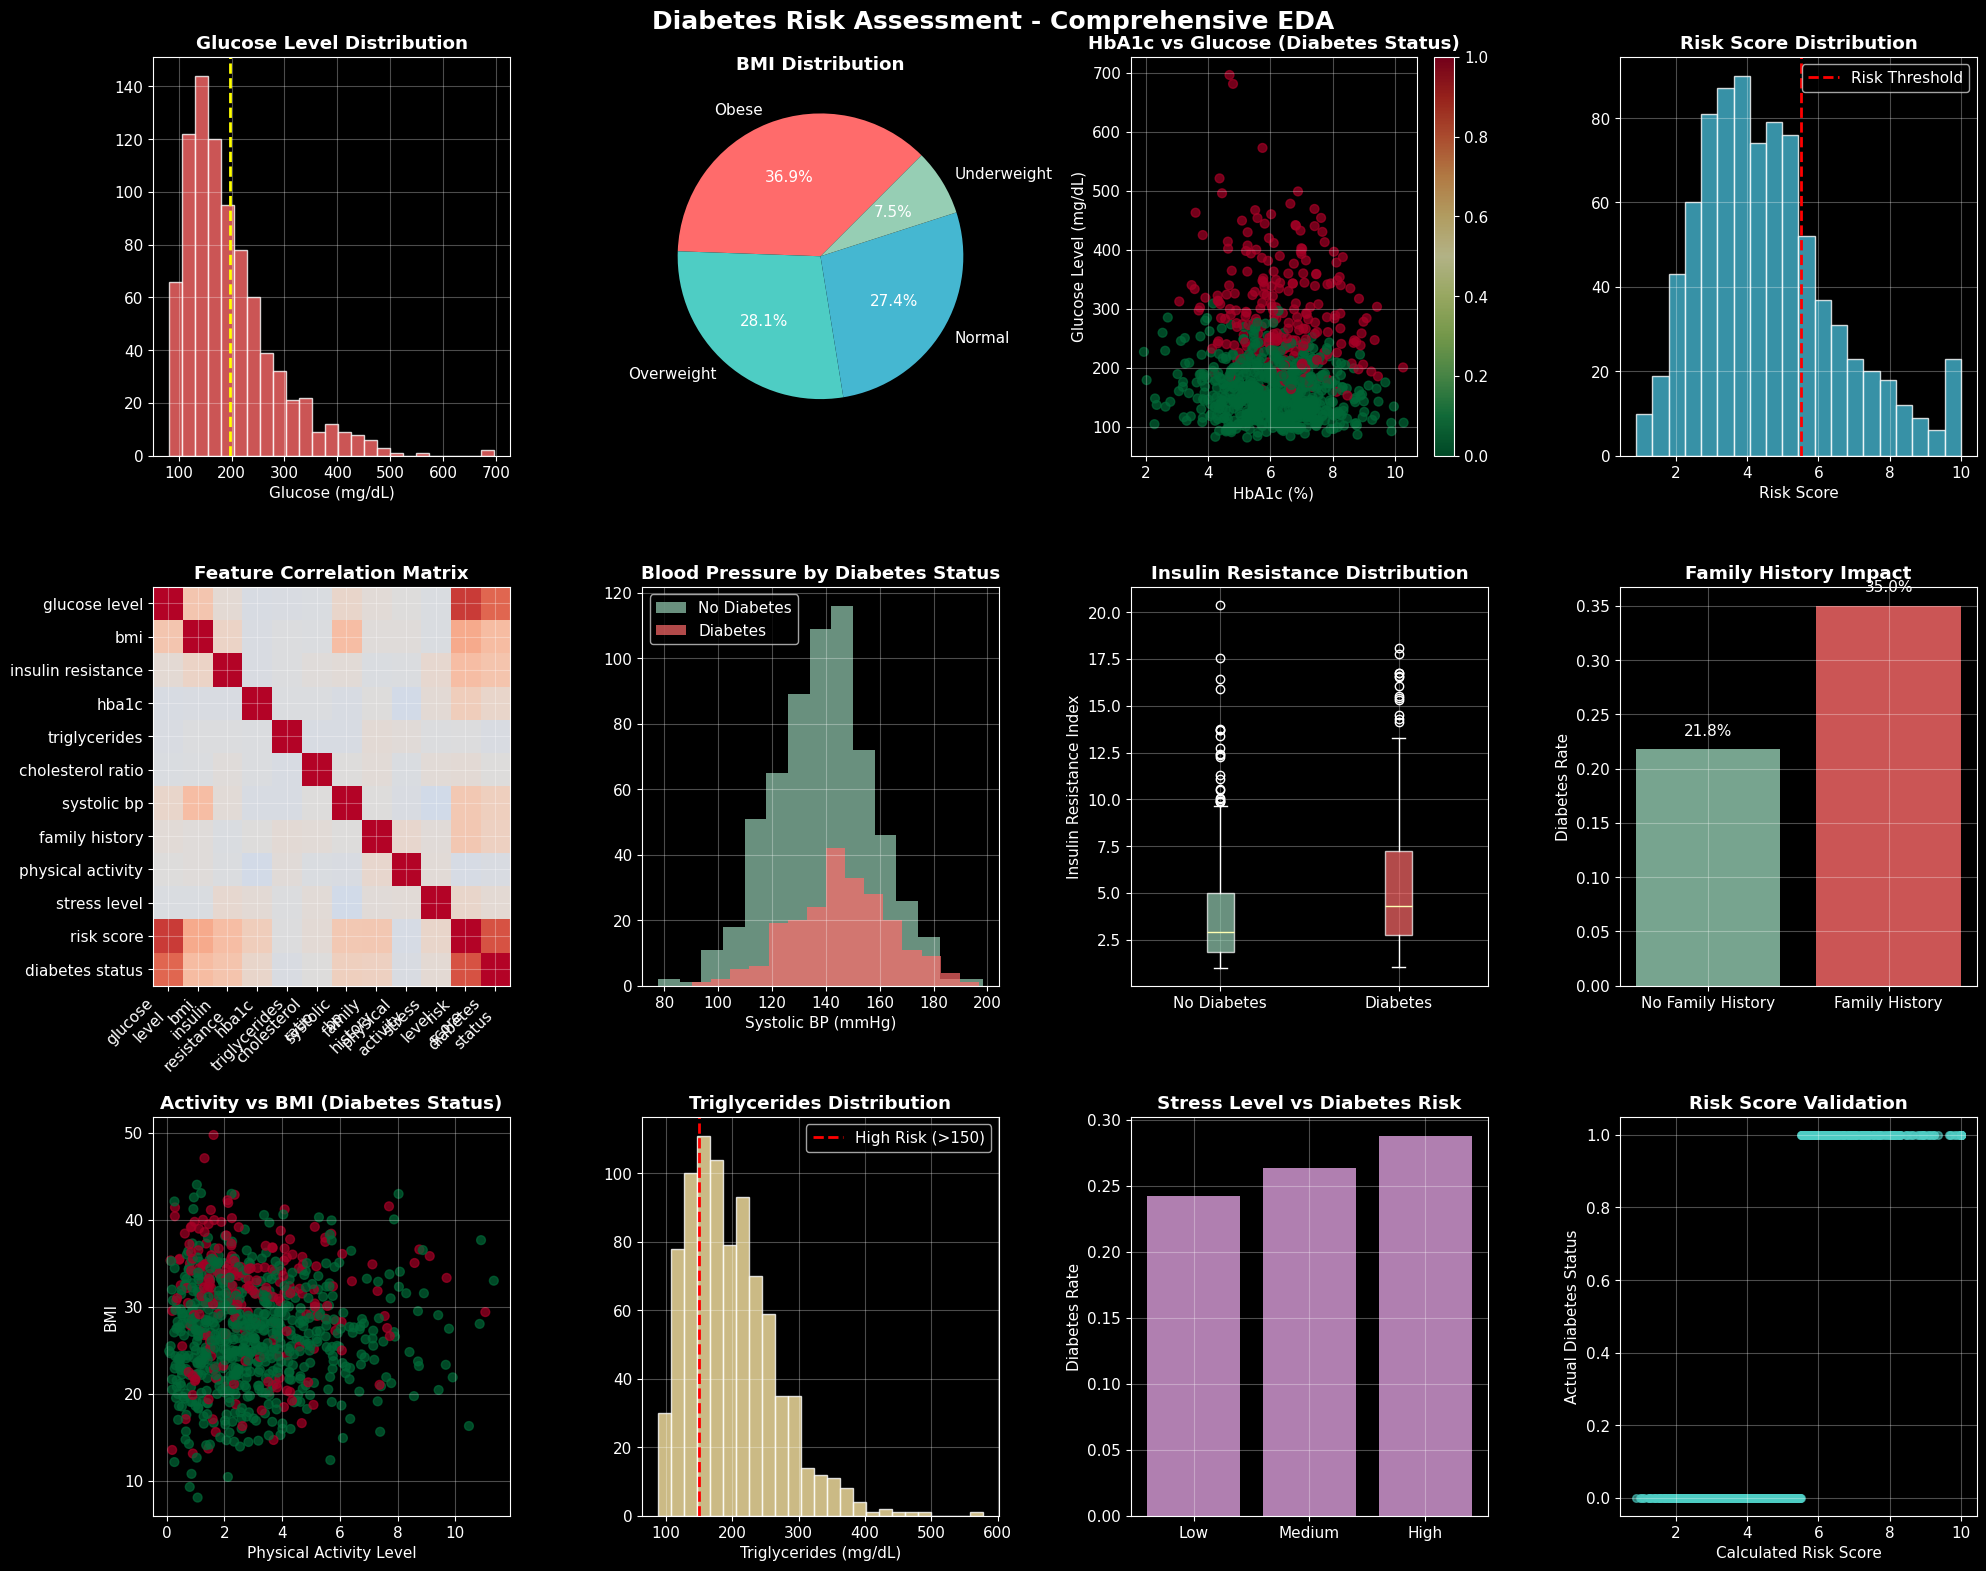

In [5]:
fig, axes = plt.subplots(3, 4, figsize=(20, 16))
fig.suptitle('Diabetes Risk Assessment - Comprehensive EDA', fontsize=18, fontweight='bold', color='white')

axes[0,0].hist(diabetes_df['glucose_level'], bins=25, alpha=0.8, color=colors[0], edgecolor='white')
axes[0,0].axvline(diabetes_df['glucose_level'].mean(), color='yellow', linestyle='--', linewidth=2)
axes[0,0].set_title('Glucose Level Distribution', fontweight='bold')
axes[0,0].set_xlabel('Glucose (mg/dL)')

bmi_categories = pd.cut(diabetes_df['bmi'], bins=[0, 18.5, 25, 30, float('inf')],
                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
bmi_counts = bmi_categories.value_counts()
wedges, texts, autotexts = axes[0,1].pie(bmi_counts.values, labels=bmi_counts.index,
                                        autopct='%1.1f%%', colors=colors[:4], startangle=45)
axes[0,1].set_title('BMI Distribution', fontweight='bold')

scatter = axes[0,2].scatter(diabetes_df['hba1c'], diabetes_df['glucose_level'],
                           c=diabetes_df['diabetes_status'], cmap='RdYlGn_r', alpha=0.7, s=40)
axes[0,2].set_xlabel('HbA1c (%)')
axes[0,2].set_ylabel('Glucose Level (mg/dL)')
axes[0,2].set_title('HbA1c vs Glucose (Diabetes Status)', fontweight='bold')
plt.colorbar(scatter, ax=axes[0,2])

axes[0,3].hist(diabetes_df['risk_score'], bins=20, alpha=0.8, color=colors[2], edgecolor='white')
axes[0,3].axvline(5.5, color='red', linestyle='--', linewidth=2, label='Risk Threshold')
axes[0,3].set_title('Risk Score Distribution', fontweight='bold')
axes[0,3].set_xlabel('Risk Score')
axes[0,3].legend()

numeric_features = diabetes_df.select_dtypes(include=[np.number]).columns
corr_matrix = diabetes_df[numeric_features].corr()
im = axes[1,0].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1,0].set_xticks(range(len(numeric_features)))
axes[1,0].set_yticks(range(len(numeric_features)))
axes[1,0].set_xticklabels([col.replace('_', '\n') for col in numeric_features], rotation=45, ha='right')
axes[1,0].set_yticklabels([col.replace('_', ' ') for col in numeric_features])
axes[1,0].set_title('Feature Correlation Matrix', fontweight='bold')

bp_diabetes = diabetes_df[diabetes_df['diabetes_status']==1]['systolic_bp']
bp_normal = diabetes_df[diabetes_df['diabetes_status']==0]['systolic_bp']
axes[1,1].hist(bp_normal, bins=15, alpha=0.7, label='No Diabetes', color=colors[3])
axes[1,1].hist(bp_diabetes, bins=15, alpha=0.7, label='Diabetes', color=colors[0])
axes[1,1].set_xlabel('Systolic BP (mmHg)')
axes[1,1].set_title('Blood Pressure by Diabetes Status', fontweight='bold')
axes[1,1].legend()

diabetes_labels = ['No Diabetes', 'Diabetes']
ir_data = [diabetes_df[diabetes_df['diabetes_status']==i]['insulin_resistance'] for i in [0,1]]
box_plot = axes[1,2].boxplot(ir_data, labels=diabetes_labels, patch_artist=True)
for patch, color in zip(box_plot['boxes'], [colors[3], colors[0]]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1,2].set_title('Insulin Resistance Distribution', fontweight='bold')
axes[1,2].set_ylabel('Insulin Resistance Index')

family_risk = diabetes_df.groupby('family_history')['diabetes_status'].mean()
bars = axes[1,3].bar(['No Family History', 'Family History'], family_risk.values,
                    color=[colors[3], colors[0]], alpha=0.8)
axes[1,3].set_title('Family History Impact', fontweight='bold')
axes[1,3].set_ylabel('Diabetes Rate')
for bar, rate in zip(bars, family_risk.values):
    axes[1,3].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{rate:.1%}', ha='center', va='bottom')

scatter2 = axes[2,0].scatter(diabetes_df['physical_activity'], diabetes_df['bmi'],
                            c=diabetes_df['diabetes_status'], cmap='RdYlGn_r', alpha=0.7, s=40)
axes[2,0].set_xlabel('Physical Activity Level')
axes[2,0].set_ylabel('BMI')
axes[2,0].set_title('Activity vs BMI (Diabetes Status)', fontweight='bold')

axes[2,1].hist(diabetes_df['triglycerides'], bins=25, alpha=0.8, color=colors[4], edgecolor='white')
axes[2,1].axvline(150, color='red', linestyle='--', linewidth=2, label='High Risk (>150)')
axes[2,1].set_title('Triglycerides Distribution', fontweight='bold')
axes[2,1].set_xlabel('Triglycerides (mg/dL)')
axes[2,1].legend()

stress_bins = pd.cut(diabetes_df['stress_level'], bins=3, labels=['Low', 'Medium', 'High'])
stress_diabetes = diabetes_df.groupby(stress_bins)['diabetes_status'].mean()
axes[2,2].bar(stress_diabetes.index, stress_diabetes.values, color=colors[5], alpha=0.8)
axes[2,2].set_title('Stress Level vs Diabetes Risk', fontweight='bold')
axes[2,2].set_ylabel('Diabetes Rate')

axes[2,3].scatter(diabetes_df['risk_score'], diabetes_df['diabetes_status'],
                 alpha=0.6, color=colors[1], s=30)
axes[2,3].set_xlabel('Calculated Risk Score')
axes[2,3].set_ylabel('Actual Diabetes Status')
axes[2,3].set_title('Risk Score Validation', fontweight='bold')

plt.tight_layout()
plt.show()

# Feature Engineering and Preprocessing

Selected clustering variables: ['glucose_level', 'bmi', 'insulin_resistance', 'hba1c', 'triglycerides', 'systolic_bp', 'physical_activity', 'stress_level']
Missing values check:
glucose_level         0
bmi                   0
insulin_resistance    0
hba1c                 0
triglycerides         0
systolic_bp           0
physical_activity     0
stress_level          0
dtype: int64
Feature standardization completed
Normalized data shape: (850, 8)


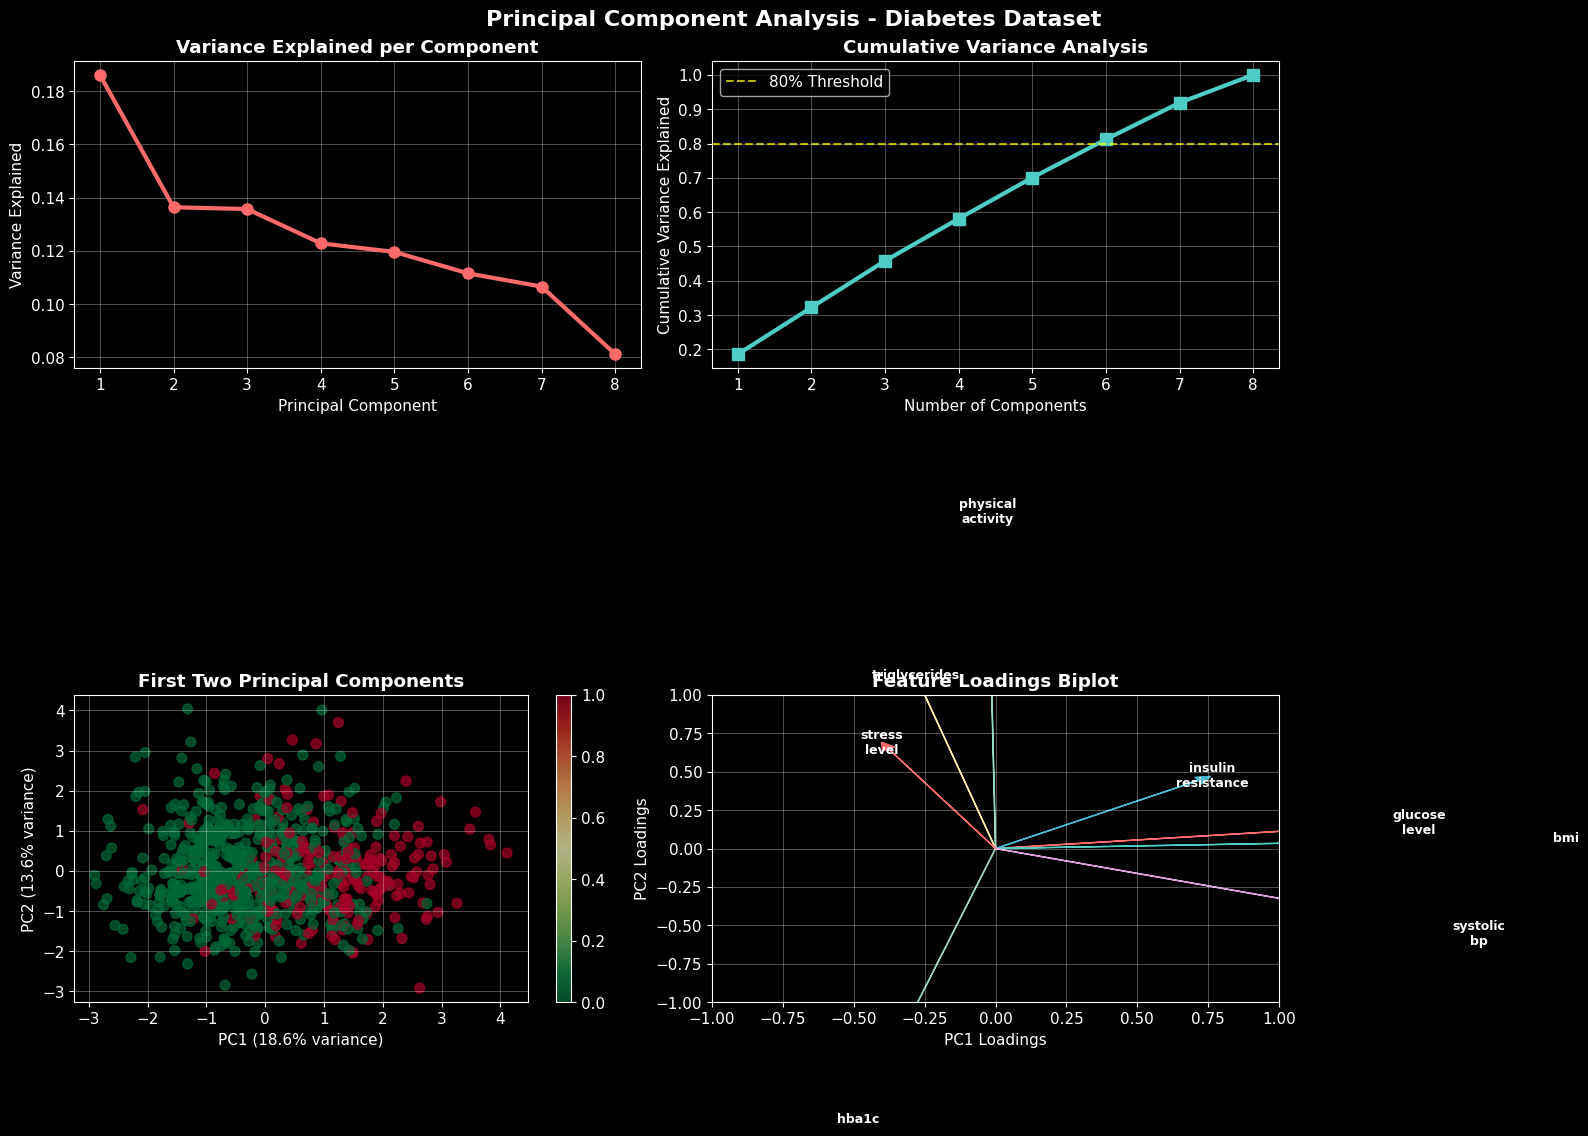

First two components explain 32.3% of total variance


In [6]:
clustering_vars = ['glucose_level', 'bmi', 'insulin_resistance', 'hba1c',
                  'triglycerides', 'systolic_bp', 'physical_activity', 'stress_level']

print(f"Selected clustering variables: {clustering_vars}")
X = diabetes_df[clustering_vars].copy()

print(f"Missing values check:")
print(X.isnull().sum())

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
print(f"Feature standardization completed")
print(f"Normalized data shape: {X_normalized.shape}")

pca = PCA()
X_pca = pca.fit_transform(X_normalized)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Principal Component Analysis - Diabetes Dataset', fontsize=16, fontweight='bold')

axes[0,0].plot(range(1, len(pca.explained_variance_ratio_) + 1),
               pca.explained_variance_ratio_, 'o-', color=colors[0], linewidth=3, markersize=8)
axes[0,0].set_xlabel('Principal Component')
axes[0,0].set_ylabel('Variance Explained')
axes[0,0].set_title('Variance Explained per Component', fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

cumulative_var = np.cumsum(pca.explained_variance_ratio_)
axes[0,1].plot(range(1, len(cumulative_var) + 1), cumulative_var,
               's-', color=colors[1], linewidth=3, markersize=8)
axes[0,1].axhline(y=0.8, color='yellow', linestyle='--', alpha=0.7, label='80% Threshold')
axes[0,1].set_xlabel('Number of Components')
axes[0,1].set_ylabel('Cumulative Variance Explained')
axes[0,1].set_title('Cumulative Variance Analysis', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

scatter = axes[1,0].scatter(X_pca[:, 0], X_pca[:, 1], c=diabetes_df['diabetes_status'],
                           cmap='RdYlGn_r', alpha=0.7, s=50)
axes[1,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[1,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[1,0].set_title('First Two Principal Components', fontweight='bold')
plt.colorbar(scatter, ax=axes[1,0])

feature_loadings = pd.DataFrame(
    pca.components_[:2].T,
    columns=['PC1', 'PC2'],
    index=clustering_vars
)

for i, (feature, loading) in enumerate(feature_loadings.iterrows()):
    axes[1,1].arrow(0, 0, loading['PC1']*3, loading['PC2']*3,
                   head_width=0.05, head_length=0.05, fc=colors[i%7], ec=colors[i%7])
    axes[1,1].text(loading['PC1']*3.2, loading['PC2']*3.2, feature.replace('_', '\n'),
                  ha='center', va='center', fontsize=9, fontweight='bold')

axes[1,1].set_xlim(-1, 1)
axes[1,1].set_ylim(-1, 1)
axes[1,1].set_xlabel('PC1 Loadings')
axes[1,1].set_ylabel('PC2 Loadings')
axes[1,1].set_title('Feature Loadings Biplot', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"First two components explain {cumulative_var[1]:.1%} of total variance")

def optimize_kmeans(data, max_clusters=8):
    """Optimized K-means evaluation with multiple metrics"""
    cluster_range = range(2, max_clusters + 1)
    inertias = []
    silhouette_scores = []
    calinski_scores = []

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=2024, n_init=10, max_iter=300)
        cluster_labels = kmeans.fit_predict(data)

        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, cluster_labels))
        calinski_scores.append(calinski_harabasz_score(data, cluster_labels))

    return cluster_range, inertias, silhouette_scores, calinski_scores

cluster_range, inertias, sil_scores, cal_scores = optimize_kmeans(X_normalized)